<a href="https://colab.research.google.com/github/kglourenco/kglourenco/blob/main/Project01_performance_Logistica_Loggi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Análise Logística: Explorando a Eficiência Operacional da Loggi no Distrito Federal.**

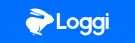

#### **Introdução:**

Este notebook tem como propósito realizar uma análise logística dos dados da empresa Loggi no Distrito Federal, buscando obter insights e informações relevantes sobre suas operações.

Nossa análise abrangerá diferentes aspectos, incluindo os hubs de entrega, as entregas realizadas, as distâncias percorridas e a proporção de entregas por região. Utilizaremos técnicas de exploração de dados e visualizações gráficas para aprofundar nosso entendimento sobre os padrões e tendências presentes nos dados.

Com base nessas análises, pretendemos fornecer informações valiosas que possam contribuir para uma compreensão mais aprofundada da logística da Loggi no Distrito Federal. Esperamos identificar pontos fortes, desafios e possíveis oportunidades de melhoria, destacando a inteligência e eficiência da empresa em suas operações logísticas.

#### **Importando as Bibliotécas:**

In [1]:
import json
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

####**Carregando os Dados:**

In [2]:
from pandas.io.formats.info import DataFrameTableBuilderVerbose
# Baixa o arquivo JSON
!wget -q "http://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

# Abrindo o arquivo JSON
with open("deliveries.json", mode="r", encoding="utf-8") as arqv:
    data = json.load(arqv)

# Criando o DataFrame deliveries_df
deliveries_df = pd.DataFrame(data)

# Visualização inicial do DataFrame
display(deliveries_df)

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
...,...,...,...,...,...
194,cvrp-1-df-59,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p..."
195,cvrp-0-df-87,df-0,"{'lng': -47.802664728268745, 'lat': -15.657013...",180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p..."
196,cvrp-1-df-83,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po..."
197,cvrp-2-df-7,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p..."


####**Explorando os dados brutos:**

Visualizando as informações presentes em em cada coluna após a transformação do arquivo JSON em um DataFrame.

In [3]:
exemple = data[0]

In [4]:
print(exemple.keys())

dict_keys(['name', 'region', 'origin', 'vehicle_capacity', 'deliveries'])


In [5]:
exemple['name']

'cvrp-2-df-33'

In [6]:
exemple['region']

'df-2'

In [7]:
exemple['origin']

{'lng': -48.05498915846707, 'lat': -15.83814451122274}

In [8]:
exemple['vehicle_capacity']

180

In [9]:
exemple['deliveries'][0]['id']

'313483a19d2f8d65cd5024c8d215cfbd'

####**Fazendo a normalização e visualização dos dados:**

In [10]:
# Normaliza a coluna 'origin'
hub_origin_df = pd.json_normalize(deliveries_df['origin'])
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)
deliveries_df = deliveries_df.drop('origin', axis=1)
deliveries_df = deliveries_df[['name', 'region', 'lng', 'lat', 'vehicle_capacity', 'deliveries']]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)

# Visualização dos dados normalizados
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


####**Fazendo a normalização e visualização dos dados das Entregas:**

In [11]:
# Explode a coluna 'deliveries'
deliveries_exploded_df = deliveries_df[['deliveries']].explode('deliveries')

# Normaliza os dados das entregas
deliveries_normalize_df = pd.concat([
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['id'])).rename(columns={"deliveries": "delivery_id"}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['size'])).rename(columns={"deliveries": "delivery_size"}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lng'])).rename(columns={"deliveries": "delivery_lng"}),
    pd.DataFrame(deliveries_exploded_df['deliveries'].apply(lambda record: record['point']['lat'])).rename(columns={"deliveries": "delivery_lat"})
], axis=1)

# Combinando os DataFrames deliveries_df e deliveries_normalize_df
deliveries_df = deliveries_df.drop("deliveries", axis=1)
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalize_df, how="right", left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

# Visualização dos dados das entregas
display(deliveries_df)

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055
...,...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,21693bf442ac5890adbdf2648c12881a,8,-48.064269,-15.997694
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,7aaa35088b37b6e542c4cd69663a7ebf,4,-48.065176,-16.003597
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,60c00d5390da4f28167439cd9c566703,9,-48.065841,-16.003808
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,51f456963785e7381243ff7baf7efd06,1,-48.062327,-16.001568


####**Cálculando e incluindo no DataFrame a visualização da distância entre os hubs e os pontos de entregas:**

In [12]:
# Calcular a distância em quilômetros entre os hubs e as entregas
deliveries_df["distance_delivery(km)"] = deliveries_df.apply(lambda row: geopy.distance.distance((row["hub_lat"], row["hub_lng"]), (row["delivery_lat"], row["delivery_lng"])).km, axis=1)

# Visualização dos dados com a coluna de distância
deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,distance_delivery(km)
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,6.663288
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,6.913095
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,6.251976
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471,6.814598
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055,6.784825


####**Geocoficação reversa dos hubs:**

In [13]:
# Criar DataFrame hub_df com as colunas region, hub_lng e hub_lat
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]]
# Remover duplicatas e ordenar por region
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
# Exibir as primeiras linhas do DataFrame
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [14]:
geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248 , -47.802664728268745")

print(json.dumps(location.raw, indent=2, ensure_ascii=False))

{
  "place_id": 68906480,
  "licence": "Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright",
  "osm_type": "node",
  "osm_id": 6456379935,
  "lat": "-15.656819",
  "lon": "-47.8019514",
  "display_name": "Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho, Região Geográfica Imediata do Distrito Federal, Região Integrada de Desenvolvimento do Distrito Federal e Entorno, Região Geográfica Intermediária do Distrito Federal, Distrito Federal, Região Centro-Oeste, 73015-202, Brasil",
  "address": {
    "amenity": "Clinica dos Olhos",
    "road": "Rua 7",
    "residential": "Quadra 2",
    "suburb": "Sobradinho",
    "town": "Sobradinho",
    "municipality": "Região Geográfica Imediata do Distrito Federal",
    "county": "Região Integrada de Desenvolvimento do Distrito Federal e Entorno",
    "state_district": "Região Geográfica Intermediária do Distrito Federal",
    "state": "Distrito Federal",
    "ISO3166-2-lvl4": "BR-DF",
    "region": "Região Centro-Oeste",
    "postcod

In [15]:
# Criar um RateLimiter com um atraso mínimo de 1 segundo entre as solicitações
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [16]:
# Adicionar as coordenadas no formato "latitude,longitude"
hub_df["coordinates"] = hub_df["hub_lat"].astype(str) + "," + hub_df["hub_lng"].astype(str)
# Aplicar o geocodificador nas coordenadas para obter as informações de geolocalização
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
# Exibir as primeiras linhas do DataFrame atualizado
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248,-47.802664728268745","(Clinica dos Olhos, Rua 7, Quadra 2, Sobradinh..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334,-47.89366206897872","(Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíl..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274,-48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [17]:
# Aplicar a normalização dos dados de geolocalização
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
# Exibir as primeiras linhas do DataFrame
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,display_name,boundingbox,address.amenity,address.road,...,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.building,address.neighbourhood,address.city,address.shop,address.house_number
0,68906480,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6456379935,-15.656819,-47.8019514,"Clinica dos Olhos, Rua 7, Quadra 2, Sobradinho...","[-15.656869, -15.656769, -47.8020014, -47.8019...",Clinica dos Olhos,Rua 7,...,BR-DF,Região Centro-Oeste,73015-202,Brasil,br,NaN,NaN,NaN,NaN,NaN
1,138610967,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,140908717,-15.80443735,-47.893155456691616,"Bloco B / F, W1 Sul, SQS 103, Asa Sul, Brasíli...","[-15.805071, -15.8038038, -47.8937468, -47.892...",NaN,W1 Sul,...,BR-DF,Região Centro-Oeste,70342-010,Brasil,br,Bloco B / F,SQS 103,Brasília,NaN,NaN
2,67585484,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,"Armazém do Bolo, lote 4/8, CSB 4/5, Taguatinga...","[-15.8384871, -15.8383871, -48.0553417, -48.05...",NaN,CSB 4/5,...,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,Taguatinga,Armazém do Bolo,lote 4/8


In [18]:
# Selecionar as colunas relevantes
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city", "address.region"]]
# Renomear as colunas
hub_geodata_df = hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city", "address.region": "hub_region"})
# Preencher os valores ausentes em "hub_city" com "hub_town"
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
# Preencher os valores ausentes em "hub_suburb" com "hub_city"
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
# Remover a coluna "hub_town"
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
# Exibir as primeiras linhas do DataFrame
hub_geodata_df.head()

,hub_suburb,hub_city,hub_region
0,Sobradinho,Sobradinho,Região Centro-Oeste
1,Asa Sul,Brasília,Região Centro-Oeste
2,Taguatinga,Taguatinga,Região Centro-Oeste


In [19]:
# Combinar os DataFrames hub_df e hub_geodata_df
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
# Selecionar as colunas relevantes
hub_df = hub_df[["region", "hub_suburb", "hub_city", "hub_region"]]
# Exibir as primeiras linhas do DataFrame
hub_df.head()

,region,hub_suburb,hub_city,hub_region
0,df-0,Sobradinho,Sobradinho,Região Centro-Oeste
1,df-1,Asa Sul,Brasília,Região Centro-Oeste
2,df-2,Taguatinga,Taguatinga,Região Centro-Oeste


In [20]:
# Combinar os DataFrames deliveries_df e hub_df
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
# Selecionar/organizando as colunas relevantes
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "hub_region", "vehicle_capacity", "delivery_id", "delivery_size", "delivery_lng", "delivery_lat", "distance_delivery(km)"]]
# Exibir o DataFrame
display(deliveries_df)

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,hub_region,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,distance_delivery(km)
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,6.663288
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,6.913095
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,6.251976
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471,6.814598
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055,6.784825
...,...,...,...,...,...,...,...,...,...,...,...,...,...
636144,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,Região Centro-Oeste,180,ed5b0db9ed16bff2514d15c646904098,2,-47.790652,-15.648593,1.589730
636145,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,Região Centro-Oeste,180,42f21b17687c57c20e6397b506a8686,5,-47.788278,-15.644174,2.097143
636146,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,Região Centro-Oeste,180,f28c6c7a584b2fc4f53dd18f50582f4c,10,-47.791276,-15.652118,1.335896
636147,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,Região Centro-Oeste,180,14f86a6068ef22a53ec6563a39e79100,10,-47.790425,-15.646404,1.760825


####**Enriquecendo a base de dados dos pontos das entregas (delivery):**

In [21]:
!wget -q "http://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [22]:
# Combinar os DataFrames deliveries_df e deliveries_geodata_df
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
# Exibir o DataFrame resultante
display(deliveries_df)

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,hub_region,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,distance_delivery(km),delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,6.663288,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,6.913095,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,6.251976,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471,6.814598,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055,6.784825,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636144,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,Região Centro-Oeste,180,ed5b0db9ed16bff2514d15c646904098,2,-47.790652,-15.648593,1.589730,Gama,Setor Oeste
636145,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,Região Centro-Oeste,180,42f21b17687c57c20e6397b506a8686,5,-47.788278,-15.644174,2.097143,Gama,Setor Oeste
636146,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,Região Centro-Oeste,180,f28c6c7a584b2fc4f53dd18f50582f4c,10,-47.791276,-15.652118,1.335896,Gama,Setor Oeste
636147,cvrp-0-df-87,df-0,-47.802665,-15.657014,Sobradinho,Sobradinho,Região Centro-Oeste,180,14f86a6068ef22a53ec6563a39e79100,10,-47.790425,-15.646404,1.760825,Gama,Setor de Indústrias - Industrial


####**Analisando a qualidade dos dados após os tratamentos:**

In [23]:
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   name                   636149 non-null  object 
 1   region                 636149 non-null  object 
 2   hub_lng                636149 non-null  float64
 3   hub_lat                636149 non-null  float64
 4   hub_city               636149 non-null  object 
 5   hub_suburb             636149 non-null  object 
 6   hub_region             636149 non-null  object 
 7   vehicle_capacity       636149 non-null  int64  
 8   delivery_id            636149 non-null  object 
 9   delivery_size          636149 non-null  int64  
 10  delivery_lng           636149 non-null  float64
 11  delivery_lat           636149 non-null  float64
 12  distance_delivery(km)  636149 non-null  float64
 13  delivery_city          634447 non-null  object 
 14  delivery_suburb        476264 non-nu

In [24]:
deliveries_df.isna().any()

name                     False
region                   False
hub_lng                  False
hub_lat                  False
hub_city                 False
hub_suburb               False
hub_region               False
vehicle_capacity         False
delivery_id              False
delivery_size            False
delivery_lng             False
delivery_lat             False
distance_delivery(km)    False
delivery_city             True
delivery_suburb           True
dtype: bool

In [25]:
(deliveries_df["delivery_city"].isna().sum() / len(deliveries_df)) * 100

0.26754738276724477

In [26]:
(deliveries_df["delivery_suburb"].isna().sum() / len(deliveries_df)) * 100

25.133262804783158

In [27]:
prop_df = (deliveries_df[["delivery_city"]].value_counts() / len(deliveries_df)) * 100
prop_df.head(10)

delivery_city       
Brasília                23.419513
Taguatinga               7.162473
Sudoeste / Octogonal     6.950416
Ceilândia                5.966055
Águas Claras             5.829295
Guará                    5.561905
Lago Sul                 4.561982
Sobradinho               4.541232
Lago Norte               4.083163
Gama                     3.488019
dtype: float64

In [28]:
prop_df = (deliveries_df[["delivery_suburb"]].value_counts() / len(deliveries_df)) * 100
prop_df.head(10)

delivery_suburb 
Brasília            8.456352
Asa Norte           7.663928
Taguatinga          6.336251
Asa Sul             5.926285
Águas Claras        5.659838
Guará               5.561905
Samambaia           2.651423
Sobradinho          1.814826
Recanto das Emas    1.502950
P Sul               1.280675
dtype: float64

A análise exploratória dos dados revela que, de maneira geral, os dados são de alta qualidade, com informações completas e consistentes. No entanto, observou-se que as colunas "delivery_city" e "delivery_suburb" possuem uma quantidade significativa de valores nulos e/ou vazios, representando 0,26% e 25,13% dos dados, respectivamente.

Além disso, identificou-se que ambas as colunas possuem o valor "Brasília" em todos os registros, o que descredibiliza a utilização dessas informações para análises mais aprofundadas. Isso ocorre porque "Brasília" não pode ser considerada uma cidade ou um subúrbio do Distrito Federal, e isso compromete a representatividade e confiabilidade desses dados.

####**Dados geográficos do Distrito Federal, para criação dos pontos (hubs e deliverys) para criação do grafico de mapa para representar o volume e area de entrega de cada hub:**

In [29]:
!wget -q "http://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [30]:
# Ler o arquivo shapefile do Distrito Federal
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [31]:
# Selecionar as colunas relevantes, remover duplicatas e redefinir o índice
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
# Criar um GeoDataFrame a partir do DataFrame de hubs
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
# Exibir as primeiras linhas do GeoDataFrame
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [32]:
# Criar um GeoDataFrame a partir do DataFrame de entregas
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
# Exibir as primeiras linhas do GeoDataFrame
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,hub_region,vehicle_capacity,delivery_id,delivery_size,delivery_lng,delivery_lat,distance_delivery(km),delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,313483a19d2f8d65cd5024c8d215cfbd,9,-48.116189,-15.848929,6.663288,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,320c94b17aa685c939b3f3244c3099de,2,-48.118195,-15.850772,6.913095,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,3663b42f4b8decb33059febaba46d5c8,1,-48.112483,-15.847871,6.251976,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,e11ab58363c38d6abc90d5fba87b7d7,2,-48.118023,-15.846471,6.814598,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,Região Centro-Oeste,180,54cb45b7bbbd4e34e7150900f92d7f4b,7,-48.114898,-15.858055,6.784825,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


####**Mapa de localização dos hubs e pontos de entregas no Distrito Federal:**

<ipython-input-33-2e89557d6192>:18: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:


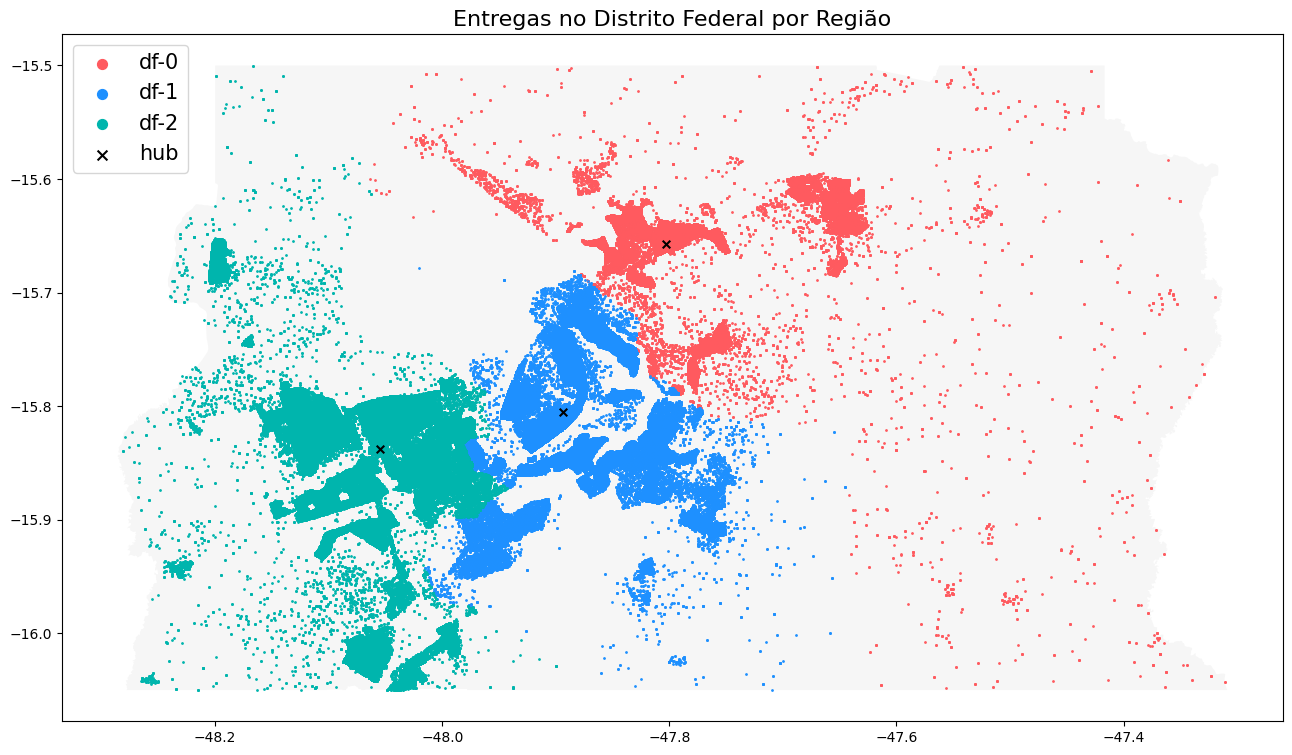

In [33]:
# Criando o plot vazio
fig, ax = plt.subplots(figsize = (40/2.54, 40/2.54))

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.2, color="lightgrey")

# plot mapa das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="#FF5A5F", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="#1E90FF", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="#00B5AD", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

O mapa acima representa a distribuição geográfica dos hubs e dos pontos de entrega no Distrito Federal por região.

Ao analisar o gráfico, é evidente que os hubs foram estrategicamente posicionados nos centros das regiões, levando em consideração as áreas de maior densidade ou volume de entregas. Isso demonstra um planejamento eficiente e uma distribuição equilibrada das operações logísticas.

#### **Explorando e analisando os dados com apoio de graficos:**

In [34]:
# Criar um DataFrame com a contagem de ocorrências normalizadas por região e capacidade do veículo
data = pd.DataFrame(deliveries_df[["region", "vehicle_capacity"]].value_counts(normalize=True)).reset_index()
# Renomear a coluna de porcentagem de região
data.rename(columns={0: "region_percent"}, inplace=True)
# Exibir DataFrame
data.head()

,region,vehicle_capacity,region_percent
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


* **Gráfico de colunas de proporção de entrega por região:**

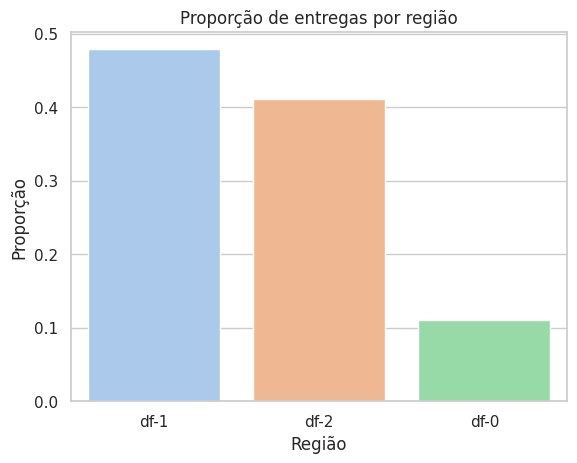

In [35]:
# Cria o DataFrame data para a proporção de entregas por região
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: 'region_percent'}, inplace=True)

# Cria o gráfico de barras da proporção de entregas por região
sns.set(style='whitegrid')
grafico = sns.barplot(data=data, x='region', y='region_percent', palette='pastel')
grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção');

O DataFrame e o gráfico acima revelam que ambos os hubs/regiões possuem a mesma capacidade de transporte, considerando os números como absolutos.

Além disso, é possível observar a representatividade percentual das entregas por região. A região df-1 se destaca como líder em volume de entregas, correspondendo a 47,89% do total de entregas realizadas no Distrito Federal. As regiões df-2 e df-3 representam, respectivamente, 41,07% e 11,02% do volume total de entregas. Essa análise percentual permite identificar a distribuição das entregas entre as regiões e destacar a importância da região df-1 como o principal centro de demanda logística no Distrito Federal.

* **Histograma de frequencia de entregas por distancia:**

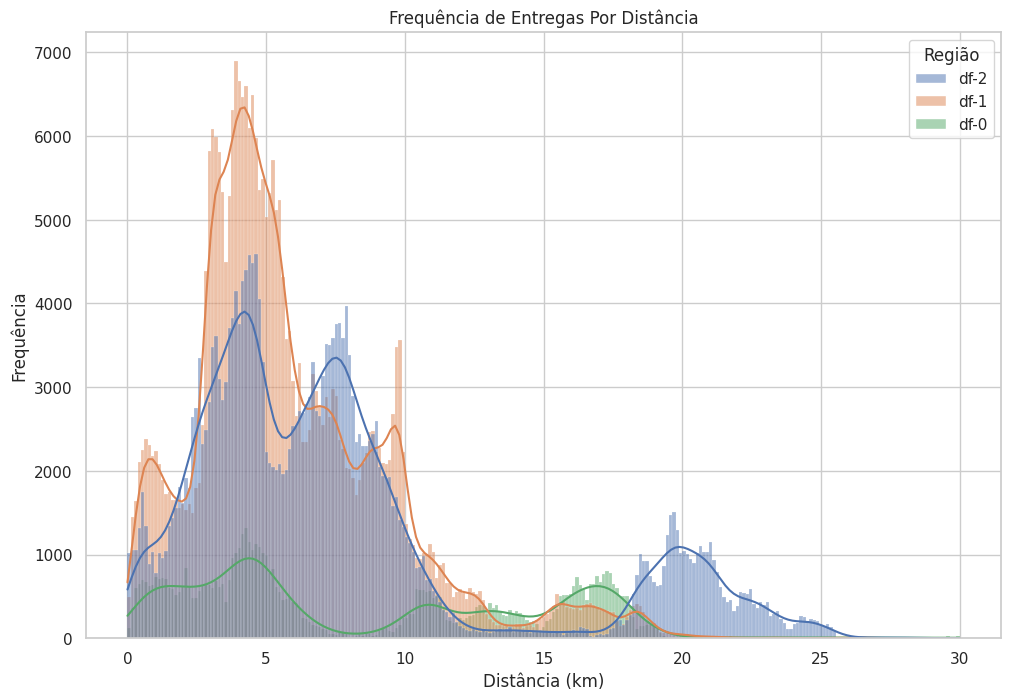

In [36]:
# Filtrar os dados com distância menor que 30 km
distance_delivery = deliveries_df[deliveries_df['distance_delivery(km)'] < 30]
# Configurar o estilo do gráfico
sns.set(style="whitegrid")
# Criar o histograma com distribuição de densidade (KDE)
grafico = sns.histplot(data=distance_delivery, x='distance_delivery(km)', hue='region', kde=True)
# Configurar os rótulos e título do gráfico
grafico.set(title='Frequência de Entregas Por Distância', xlabel='Distância (km)', ylabel='Frequência');
grafico.get_legend().set_title('Região')
grafico.figure.set_size_inches(w=30/2.54, h=20/2.54)

O gráfico acima mostra a frequência de entregas em relação à distância em quilômetros, confirmando que a Loggi é muito eficiente na realização de entregas e na distribuição de mercadorias em curtas distâncias. Em todas as regiões, a maior frequência de entregas ocorre em distâncias próximas de 5 km. Isso demonstra que a Loggi é capaz de atender com agilidade e rapidez às demandas locais, contribuindo para uma entrega mais eficiente e satisfatória para os clientes. A capacidade de realizar entregas em curtas distâncias é um diferencial importante da Loggi, pois reduz os tempos de transporte e permite uma maior rapidez na distribuição das mercadorias.

* **Gráfico Box Plot de distribuição do renge de atuação entrega em km por região:**

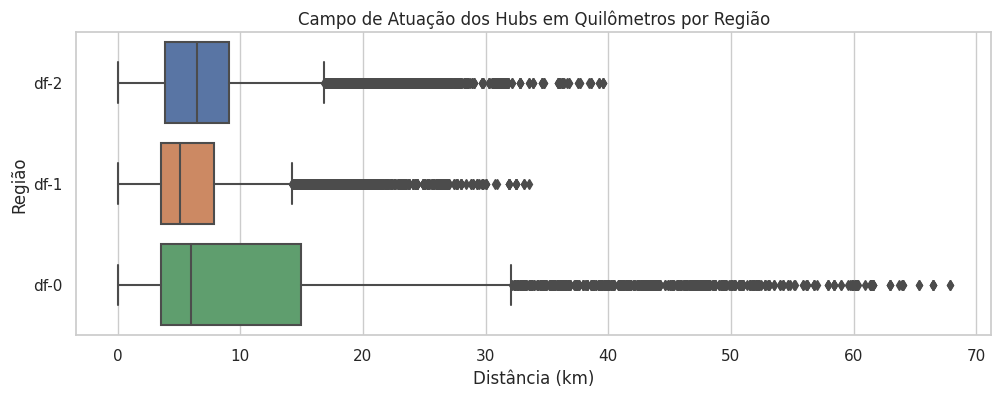

In [37]:
# Criar um gráfico de caixa (boxplot) para cada região
sns.set(style="whitegrid")
grafico = sns.boxplot(data=deliveries_df, x="distance_delivery(km)", y="region")
grafico.set(title="Campo de Atuação dos Hubs em Quilômetros por Região", xlabel="Distância (km)", ylabel="Região");
grafico.figure.set_size_inches(w = 30/2.54, h = 10/2.54)

O gráfico acima evidencia o motivo pelo qual todas as regiões possuem a mesma capacidade de entrega. Nele, é fácil observar que as regiões com maior volume de entregas, conforme mostrado no gráfico anterior, apresentam medianas (representadas pelas caixas), quartis (representados pelas linhas) e outliers (representados pelos pontos) menores. Isso indica que, mesmo com volumes de entregas maiores, essas regiões possuem uma área de abrangência menor, enquanto as regiões com menor volume de entregas lidam com entregas mais distantes, percorrendo maiores distâncias. Essa estratégia evidencia a inteligência logística da Loggi ao otimizar a distribuição das entregas de forma equilibrada entre os hubs, considerando tanto o volume de demanda quanto a eficiência do transporte.

* **Gráfico de barras com com a distância média percorrida nas entregas por região:**

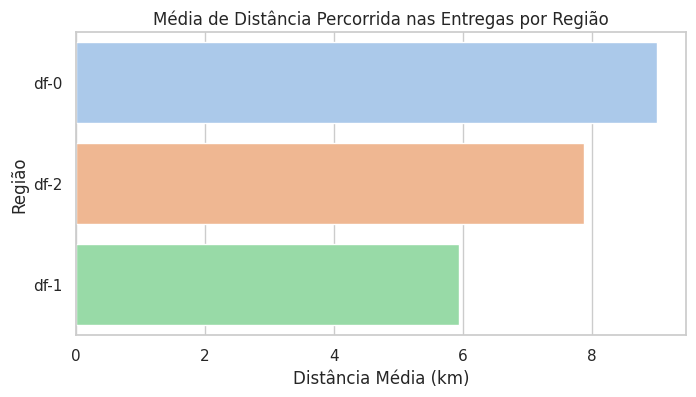

In [38]:
# Calcular a média da distância por região
media_distancia = deliveries_df.groupby("region")["distance_delivery(km)"].mean()

# Ordenar o DataFrame pela coluna 'distance_delivery(km)' em ordem decrescente
media_distancia = media_distancia.sort_values(ascending=False)

# Criar o gráfico de colunas horizontais
sns.set(style="whitegrid")
grafico = sns.barplot(data=deliveries_df, y=media_distancia.index, x=media_distancia.values, palette="pastel", orient="h")

# Configurar os rótulos e título do gráfico
grafico.set(title="Média de Distância Percorrida nas Entregas por Região", xlabel="Distância Média (km)", ylabel="Região")
grafico.figure.set_size_inches(w=20/2.54, h=10/2.54)

O gráfico acima reforça a ideia de distribuição das entregas, mostrando que as regiões com maior concentração de entregas apresentam as menores médias de quilometragem percorrida nas entregas realizadas. Isso indica que a Loggi tem efetivamente direcionado suas operações para atender de forma mais eficiente as regiões com maior demanda, evitando deslocamentos excessivos e otimizando o tempo de entrega. Essa estratégia contribui para uma logística mais eficaz e para a satisfação dos clientes, uma vez que as entregas são realizadas de maneira mais rápida e eficiente.

* **Analise geral das informações:**

Após analisar os dados disponíveis, podemos destacar a inteligência e eficiência da Loggi em suas operações logísticas no Distrito Federal. A empresa apresenta uma distribuição estratégica de hubs e pontos de entrega, levando em consideração as áreas de maior demanda e densidade populacional.

Uma observação relevante é a equilibrada capacidade de transporte entre as regiões, evidenciando um planejamento cuidadoso para atender de forma eficiente todas as áreas do Distrito Federal. Essa distribuição equitativa contribui para otimizar o tempo de entrega e garantir a satisfação dos clientes.

Além disso, a Loggi se destaca ao direcionar seus esforços para as regiões com maior demanda, concentrando suas operações logísticas em áreas de alto volume de entregas. Essa estratégia permite uma distribuição eficiente e reduz a necessidade de deslocamentos em longas distâncias.

A empresa também demonstra habilidade em realizar entregas em curtas distâncias, o que é confirmado pela frequência de entregas concentrada em torno de 5 km. Essa eficiência na distribuição contribui para agilizar o processo de entrega e atender às demandas locais de forma rápida e satisfatória.

Em suma, a Loggi se destaca por sua inteligência logística e capacidade de adaptação às necessidades do mercado. A empresa utiliza estratégias eficientes na distribuição de suas operações, levando em consideração a densidade populacional, demanda e distâncias envolvidas. Essa abordagem inteligente resulta em uma logística ágil, eficaz e de alta qualidade, que contribui para o sucesso da empresa e a satisfação dos clientes.